<h1>Recommendation Function<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Library" data-toc-modified-id="Loading-Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Library</a></span></li><li><span><a href="#Function-Algorithm" data-toc-modified-id="Function-Algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Algorithm</a></span><ul class="toc-item"><li><span><a href="#Algorithm-Visualization" data-toc-modified-id="Algorithm-Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Algorithm Visualization</a></span></li><li><span><a href="#Algorithm-by-Steps" data-toc-modified-id="Algorithm-by-Steps-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Algorithm by Steps</a></span><ul class="toc-item"><li><span><a href="#Get-Similarity-List" data-toc-modified-id="Get-Similarity-List-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Get Similarity List</a></span></li><li><span><a href="#Query-Preprocessing" data-toc-modified-id="Query-Preprocessing-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Query Preprocessing</a></span></li><li><span><a href="#Product-Matching" data-toc-modified-id="Product-Matching-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Product Matching</a></span></li><li><span><a href="#Recommendation-Outfit" data-toc-modified-id="Recommendation-Outfit-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Recommendation Outfit</a></span></li></ul></li></ul></li><li><span><a href="#Define-Functions" data-toc-modified-id="Define-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Functions</a></span><ul class="toc-item"><li><span><a href="#Data-Clean-Functions" data-toc-modified-id="Data-Clean-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Clean Functions</a></span></li><li><span><a href="#Similarity-Calculation-Functions" data-toc-modified-id="Similarity-Calculation-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Similarity Calculation Functions</a></span></li><li><span><a href="#Query-Preprocessing-Functions" data-toc-modified-id="Query-Preprocessing-Functions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Query Preprocessing Functions</a></span></li><li><span><a href="#Recommendation-Matching-Functions" data-toc-modified-id="Recommendation-Matching-Functions-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Recommendation Matching Functions</a></span></li></ul></li><li><span><a href="#Put-into-Use" data-toc-modified-id="Put-into-Use-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Put into Use</a></span></li></ul></div>

# Loading Library

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords, wordnet
from nltk import punkt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import spacy
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load('en_core_web_lg')


/Users/haoyanzhang/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Function Algorithm

## Algorithm Visualization

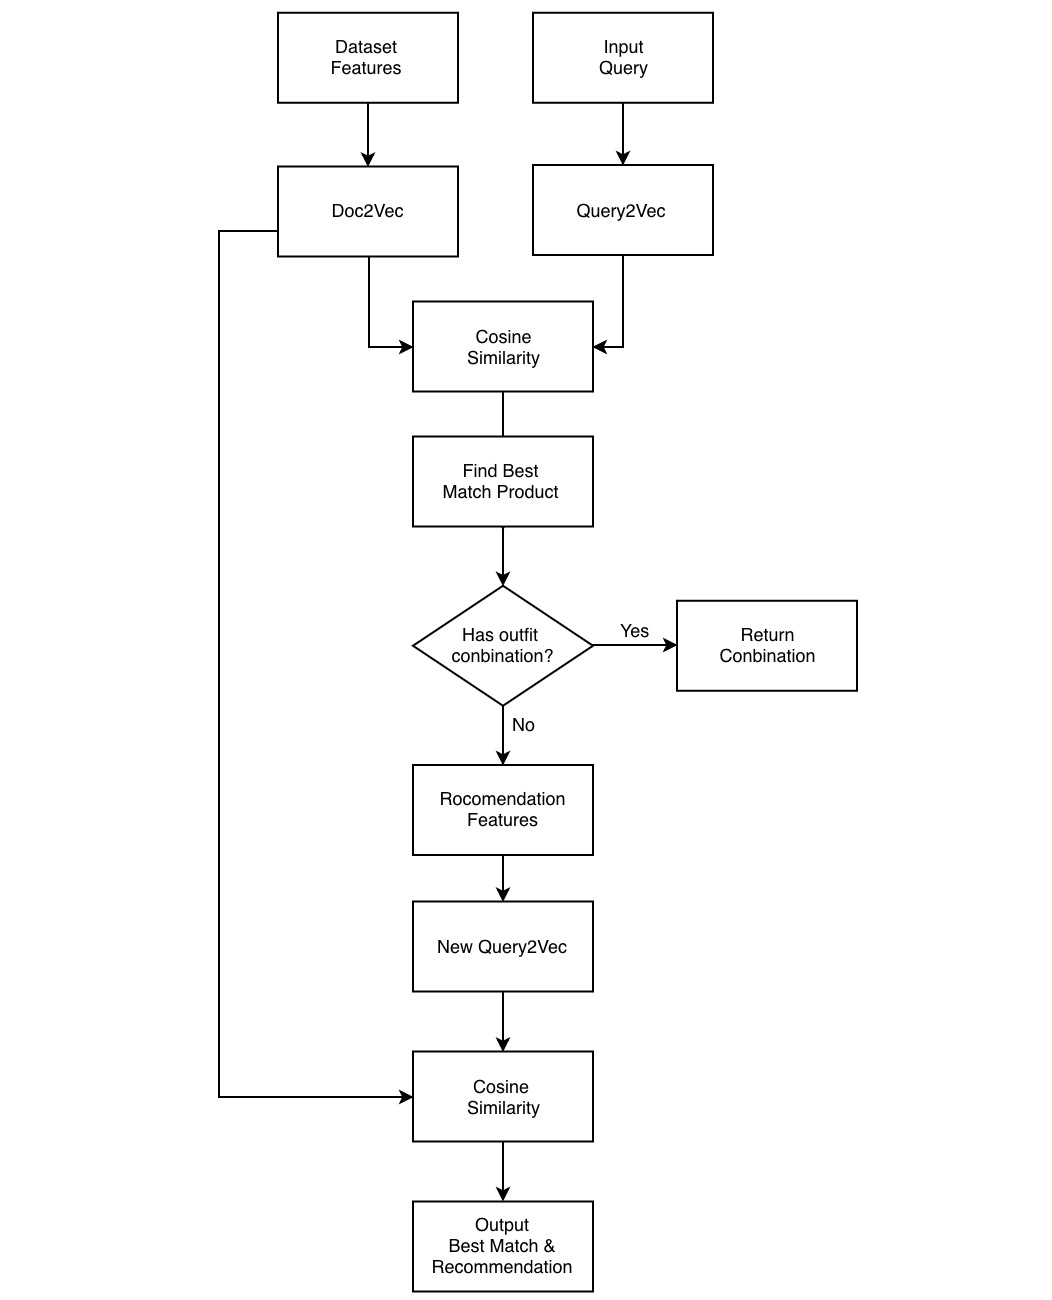

In [2]:
from IPython.display import Image
Image(filename='Algorithm.jpeg')

## Algorithm by Steps

### Get Similarity List

1. `calculateTFIDF`
    - After generating all relative features, input all 60,000+ records' product_doc information, which is the product self features into TF-IDF vectorizer function `TFidfVectorizer` and get the TF-IDF weighting. This step will output the vectorizer, tf-idf table as dataframe, and the tf-idf score for further use. The vectorizer will also be used in query vectorization.  
    
    
2. `word2VecWeightTFIDF`
    - Using the output from `calculateTFIDF` and word2vec to convert product feature record documents to vectors, weighted by the tf-idf score. We limit the representing vector length as 300, so that all product features will be converted into a 300 character length vector.  
    
    
3. `getProductVector`
    - Return the list of vectors that represent each product by the order in the original dataframe.  
    
    
4. `queryTFIDF`
    - Calculate the tf-idf score for the query, output the tf-idf score for that query used in next step's word2vec weighting.  
    
    
5. `queryToVecWeight`
    - Calculate the word2vec vector of the query that is weighted by tf-idf score from former step.  
    
    
6. `getQueryVector`
    - Return the list of vectors that represent the query  
    
    
7. `getSimilarity`
    - Calculate the cosine similarity between query and each document, return the descending similarity list

### Query Preprocessing

1. `find_query_category`
    - We first preprocess the query and the original data to make sure their category can match to each other. Then we will find the category of the input query, if the input query describe specific category, we will recommend a product of that category  
    
    
2. `find_query_brand`
    - We first preprocess the query and the original data to make sure their brand can match to each other. Then we will find the brand of the input query, if the input query mentions specific brand, we want to return a product of that brand  
    
    - Here we also implemented fuzzy match to make sure if user searching for a brand that has "\." in it, for example "J.Crew", we can match the "J crew" to the actual brand name "J.Crew" instead of removing "\." . Thus, we choose to use fuzzy match, score for all matched tokens and take the top one, which should be the brand name.

### Product Matching

1. `find_final_product_id`
    - First we try to find the category and the brand of the query, if the query does not mention any information about category and brand, we just return the first product id in the similarity list which has the highest similarity score.
    - If the query mention about category, but does not mention about brand, we will return the first product id in the similarity list that match the query category.
    - If the query mention about brand, but does not mention about category, we will first search for all product that belongs to that brand and return the first product id in the similarity list that match the query brand. Also, the brand may not produce products in the category that mentioned in the query. In this situation, we will discard the brand information and return first product id in the similarity list which has the highest similarity score   
    - If the query mention about both category and brand, we will return the first product id in the similarity list that match the query category and query brand. Also, the brand may not produce products in the category that mentioned in the query. In this situation, we will discard the brand information and return the product id only consider the brand's category.

### Recommendation Outfit

Now we have the closest product that the user is looking for, we will then search for the outfit recommendations.  
This includes two situations: If output product is in our expert outfit combination, we would return the recommended combination; else if the output product has no exist recommended outfit combination, we will search for our recommendation doc of that product and calculate similarity with all other products, and recommend the closest product combinations.

1. `recommand_outfit_combinations`
    - Find whether final product is in the outfit_combinations: If true then return the list, otherwise return []. If our final product id is in the outfit_combinations product id list, we will return the curated set of outfits picked by experts.
    
2. `recFind`
    - Find recommendation similarity list: used when output product is not in our expert outfit list
    
3. `search_for_recommand`
    - If our final product id is not in the existing outfit_combinations, we will search for our own recommendation. In this step, we will search for the top 3 similar products that belongs to 3 different categories.
    
4. `recommendation`
    - Recommendation Function that combines previous steps
    
5. `getRecommendation`
    - User used function that takes in a query and output the recommended outfit.

# Define Functions

## Data Clean Functions

In [3]:
def spacyTokenizer(document):
    '''Use spacy package to perform tokenize, remove punctuation and lemmatize the word'''
    tokens = nlp(document)
    tokens = [token.lemma_ for token in tokens if (
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

def nltk_tag_to_wordnet_tag(nltk_tag):
    '''function to convert nltk tag to wordnet tag'''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    '''Use NLTK package to perform lemmatize'''
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(lemmatized_sentence)

def remove_sw(text):
    '''Use NLTK to remove stopword'''
    from nltk.corpus import stopwords
    from nltk import word_tokenize
    #using english stop word in NLTK
    stopwords_list = stopwords.words('english')

    import re

    # split sentence into words
    words = word_tokenize(text)

    new_words = []
    # remove stopwords
    for w in words:
        if w in stopwords_list:
            continue
        new_words.append(w)

    return ' '.join(new_words)


def textClean(text):  
    '''Lemmatize and remove srop word'''
    return(remove_sw(lemmatize_sentence(text)))

## Similarity Calculation Functions

In [4]:
def calculateTFIDF(text_list):
    '''Calculate the tf-idf given a list of documents, and return the vectorizer, tf-idf table dataframe, and the token available
    reference: https://colab.research.google.com/drive/1CZa723-_mDmNJPG2oiExgWYF9nqbueeY?usp=sharing'''
    from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
    #Define generate TF-idf Vectorizer for each document
    vectorizer = TfidfVectorizer(
        #token_pattern=r'\b[a-zA-Z]+\b'
        tokenizer = spacyTokenizer
        #ngram_range = (1,2)
    )
    #fit the vectorizer to the text list
    X = vectorizer.fit_transform(text_list)
    #Get tf-idf table
    tf_idf_lookup_table = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    DOCUMENT_SUM_COLUMN = "DOCUMENT_TF_IDF_SUM"
    # sum the tf idf scores for each document
    tf_idf_lookup_table[DOCUMENT_SUM_COLUMN] = tf_idf_lookup_table.sum(axis=1)
    available_tf_idf_scores = tf_idf_lookup_table.columns 
    # a list of all the columns we have
    available_tf_idf_scores = list(map( lambda x: x.lower(), available_tf_idf_scores)) 
    # lowercase everything
    return vectorizer, tf_idf_lookup_table, available_tf_idf_scores

In [5]:
def word2VecWeightTFIDF(doc_list, tf_idf_lookup_table, available_tf_idf_scores):
    '''Calculate the word2vec of each document and weighted by tf-idf socre
    reference: https://colab.research.google.com/drive/1CZa723-_mDmNJPG2oiExgWYF9nqbueeY?usp=sharing'''
    import numpy as np

    doc_vectors = []
    for idx, doc in enumerate(doc_list): # iterate through each review
        tokens = nlp(doc) # have spacy tokenize the review text

        # initially start a running total of tf-idf scores for a document
        total_tf_idf_score_per_document = 0

        # start a running total of initially all zeroes (300 is picked since that is the word embedding size used by word2vec)
        running_total_word_embedding = np.zeros(300) 
        for token in tokens: # iterate through each token

        # if the token has a pretrained word embedding it also has a tf-idf score
            if token.has_vector and token.text.lower() in available_tf_idf_scores:

                tf_idf_score = tf_idf_lookup_table.loc[idx, token.text.lower()]
                #print(f"{token} has tf-idf score of {tf_idf_lookup_table.loc[idx, token.text.lower()]}")
                running_total_word_embedding += tf_idf_score * token.vector

                total_tf_idf_score_per_document += tf_idf_score
                
        #if no token has has a pretrained word embedding, assign 1 to aviod zero division
        if total_tf_idf_score_per_document == 0:
            total_tf_idf_score_per_document = 1

        # divide the total embedding by the total tf-idf score for each document
        document_embedding = running_total_word_embedding / total_tf_idf_score_per_document
        #print(document_embedding)
        doc_vectors.append(document_embedding)
    return doc_vectors
    

In [6]:
def getProductVector(text_df):
    '''Return the list of vectors that reperesent each product'''
    vectorizer, tf_idf_lookup_table, available_tf_idf_scores = calculateTFIDF(text_df)
    print("TF-IDF Vectorizing Finished.")
    product_vectors = word2VecWeightTFIDF(text_df, tf_idf_lookup_table, available_tf_idf_scores)
    print("Word2Vec  Finished.")
    return product_vectors, vectorizer

In [7]:
def queryTFIDF(query, vectorizer):
    '''Calculate the tf-idf score given a query and vectorizer'''
    query_pre_tf_idf = [textClean(query)]
    #Clean the query
    query_tf_idf = vectorizer.transform(query_pre_tf_idf)
    #Calculate the score given fitted vectorizer 
    query_tf_idf_lookup_table = pd.DataFrame(query_tf_idf.toarray(), columns=vectorizer.get_feature_names())
    #Get query tf-idf table
    available_tf_idf_scores = query_tf_idf_lookup_table.columns 
    # a list of all the columns we have
    available_tf_idf_scores = list(map( lambda x: x.lower(), available_tf_idf_scores)) 
    # lowercase everything
    return query_tf_idf_lookup_table, available_tf_idf_scores

In [8]:
def queryToVecWeight(query, query_tf_idf_lookup_table, available_tf_idf_scores):
    '''Calculate the word2vec of the query and weighted by tf-idf socre'''
    query_clean = [textClean(query)]
    #clean the query
    return word2VecWeightTFIDF(query_clean, query_tf_idf_lookup_table, available_tf_idf_scores)
    

In [9]:
def getQueryVector(query, vectorizer):
    '''Return the list of vectors that reperesent the query'''
    query_tf_idf_lookup_table, available_tf_idf_scores = queryTFIDF(query, vectorizer)
    query_vectors = queryToVecWeight(query, query_tf_idf_lookup_table, available_tf_idf_scores)
    return query_vectors

In [10]:
def getSimilarity(total_doc, query_vector, index_name):
    '''Calculate the cosine similarity between query and each document, return the descending similarity list'''
    similarities = pd.DataFrame(cosine_similarity(total_doc, query_vector), columns=['similarity'], index=index_name)
    #Calculate the cosine similarity
    return similarities['similarity'].sort_values(ascending = False)

## Query Preprocessing Functions

In [11]:
def find_query_category(txt): 
    '''find the category of the input query, if the input query describe specific category, we want to recommend a product of that category'''
    
    # define the pattern for each category
    top_re=r'\b(top|shirt|tee|blouse|tank|tshirt|knitwear|vest|camisole|overshirt|long sleeve|v neck|tunic|turtleneck|shell|sleeve|polo|cami|slvls|vneck|shrt|pckt t|crew|sleeveless|sweatshirt|longsleeve|hoodie|pullover|sweat|crewneck|pullovr|swtshrt)\b'
    outwear_re = r'\b(jacket|coat|blazer|outerwear|trench|parka|anorak|puffer|overcoat|topcoat|bomber|trucker|jckt|blazr|jkt)\b'
    bottom_re = r'\b(jean|pant|jogger|skirt|short|trouser|legging|leg|skort|bottom|low straight|loose straight|straight fit|loose fit|relax straight|relaxed straight|vintage straight|slim taper|sweatpants?|miniskirt|culotte|bootcut|dojo|crop|skinny|stretch denim|slimmy|high rise|low rise|mid rise|garment|paxtyn|ankle|denim slimmy|high waist|flare|skny|exaggerate kick)\b'
    shoe_re = r'\b(sandal|booty|shoe|sneaker|boot|pump|flat|heel|bootie|mule|espadrille|oxford|loafer|slipper|flip flop|clog|derby|slip on|wedge|slide|nappa|leather upper)\b'
    sweater_re=r'\b(sweater|cardigan|knitwear|swtr)\b'
    onepiece_re = r'\b(dress|jumpsuit|shirtdress|dressesandjumpsuits?|bodysuit|housedress|rompers?|kimono|robe|one piece|onepiece|minidress|denim set|pj set|short set|lounge set|sleep set|cami set|trouser set|pajama set|pc set|bra set|slipdress|pantsuit|shirtdress|raincoat|caftan|suit|slip|jump|jumpsut)\b'
    accessory_re = r'\b(bags?|tote|crossbody|handbags?|belt|tie|accessory|ladybag|backpack|gymsack|cardholder|glove|wristlet|sunglass|satchel|leash|laptop|camera|jewelry|wallet|eyewear|scarf|scarves|clutch|poncho|calendar|bangle|keychain|mat|postcard|tumbler|pouch|hobo|hat|earring|barrette|haircalf|box|cape|mask|mitt|sock|wrap|jasper|bracelet|necklace|scrunchie|biker|millinery|card|fedora|felt|pack|napkin|shawl|hook|chain|spray|diffuser|brim|cap|blanket|josefina|bottle|basket|eye|extérieure|paint|mousse|glass|collection|acrylic|accessory|clip|beanie|beret)\b'
    underwear_re = r'\b(bra|underwear|bralett|bralette|thong|panty|underwire|brakini)\b'
    othercloth_re=r'\b(wears?|classic fit|regular fit|denim|cloth|othercloth)\b'
    home_re=r'\b(candle|vase|mug|pot|chair|mist|towel|lamp|glasswear|plate|pillow|table|coverlet|sofa|bed|desk|bowl|dish|bath|jar|soap|handwoven|chèvre|wash|home)\b'
    cosmetics_re=r'\b(sanitizer|cream|lip|oil|perfume|perfum|nail)\b'
    book_re=r'\b(books?|lookbook|workbook)\b'
    archive_re=r'\barchive\b'

    # use regular expression to find the brand of the query
    # if we cannot find a category for the query, we put 'unknow'
    txt = str(txt)
    val = np.nan
    if re.search(shoe_re, txt, re.IGNORECASE ):
        val = "shoe"
    elif re.search(onepiece_re, txt, re.IGNORECASE ):
        val = "onepiece"    
    elif re.search(bottom_re, txt, re.IGNORECASE ):
        val = "bottom"
    elif re.search(top_re, txt, re.IGNORECASE ):
        val = "top"
    elif re.search(outwear_re, txt, re.IGNORECASE ):
        val = "outwear"
    elif re.search(sweater_re, txt, re.IGNORECASE ):
        val = "sweater"   
    elif re.search(underwear_re, txt, re.IGNORECASE ):
        val = "underwear"
    elif re.findall(othercloth_re, txt, re.IGNORECASE ):
        val = "othercloth"
    elif re.search(accessory_re, txt, re.IGNORECASE ):
        val = "accessory"
    elif re.search(home_re, txt, re.IGNORECASE ):
        val = "home"
    elif re.search(cosmetics_re, txt, re.IGNORECASE ):
        val = "cosmetics"
    elif re.search(book_re, txt, re.IGNORECASE ):
        val = "book"
    elif re.search(archive_re, txt, re.IGNORECASE ):
        val = "archive"
    else:
        val = "unknow"
    return val

In [12]:
def find_query_brand(txt):
    '''find the brand of the input query, if the input query mentions specific brand, we want to return a product of that brand'''
    txt = str(txt)
    brand_list = list(data['brand'].unique())
    # define the brand pattern
    brand_re=r'\b(Two|Collina Strada|Cariuma|Maia Bergman|Misa|Banjanan|Rails|Rachel Comey|Nomasei|Aera|AG|Prism|Monogram|Frame|Tibi|EMME PARSONS|Studio 189|Joie|Staud|Vince|Avavav|ROTATE|Batsheva|Chufy|Gigi Burris|Warm|Holden|Nili Lotan|Simon Miller|Jonathan Cohen|Hyer Goods|Whit|Christina Lehr|Tanya Taylor|Behold Kim\'s Dresses|G. Label|G. Sport|Theory|Wandler|Goldsign|MadeWorn|St. Agni|BERNARDO|Cult Gaia|Equipment|La DoubleJ|Jimmy Choo|Zimmermann|ATP Atelier|Helmut Lang|Acne Studios|Axel Arigato|Dr. Martens|Mara Hoffman|Nobody Denim|Ulla Johnson|ANINE BING|GRLFRND Denim|MOTHER|Studio Amelia|Alo Yoga|Little Liffner|LoveShackFancy|We Are Kindred|Jenni Kayne|Loeffler Randall|Stuart Weitzman|Alexandre Birman|Varley US|Significant Other|I Love Mr. Mittens|Isabel Marant Étoile|Manolo Blahnik|Nicholas Kirkwood|THE OFFICE OF ANGELA SCOTT|Eleven Six|Araks|lemlem|Janessa Leone|Sea|7 For All Mankind|Re/done|BROCHU WALKER|Sandy Liang|Kin the Label|Clare V.|Jason Scott|Andrea Iyamah|6397|Cynthia Rowley|Triarchy|Intentionally Blank|ALO|LTH JKT|Ciao Lucia|Nike|Nu Swim|Lowercase|ASTR the Label|Mother Denim|Trovata|Cesta Collective|Aesther Ekme|Mari Giudicelli|St. Roche|CQY|Illesteva|A.L.C.|House of Fluff|Cara Cara|E.L.V. Denim|Nuance|Les Girls Les Boys|Urban Savage|Either / Or|Merlette|Esquivel|LE SUPERBE|Alumnae|Zonarch|M.M.LaFleur|Veja|Gigi New York|Alexander Wang|Ancient Greek Sandals|Faherty|Outerknown|Want Les Essentiels|Tkees|Matthew Bruch|Gray Matters|Vaara|Vee Collective|Tallulah & Hope|Karla Colletto|Mackage|Behold Demo Shop (Shopify)|Demellier|AMO|Co|YCH|AMUR|Khaite|LOQ|Marni|Rhode|RtA|Acler|Akris|Anaak|Atoir|BOSS|Ellery|Ganni|Haight|J.Crew|Loewe|MONSE|Prada|ROAN|Skin|USISI|WONE|Xirena|A Emery|AMIRI|Agolde|Alexis|Asceno|Attico|Bassike|Bourie|By Far|Chloé|DÔEN|Gucci|Khaore|Koral|MATIN|Nanushka|Partow|REISS|TOD\'S|Toteme|Youser|aeydē|Alanui|Allude|Anemone|Cefinn|Chylak|Deveaux|JORDAN|Joseph|LEGRES|Matteau|WILLOW|Yuzefi|Alex Mill|Altuzarra|Anna Sui|Cushnie|Givenchy|Halston|J Brand|K Jacques|Max Mara|Nagnata|The Row|Alix NYC|Anna Quan|Aquazzura|Bouguessa|CASASOLA|Cami NYC|Derek Lam|Eve Denim|Jacquemus|L\'Agence|La Ligne|Le Kasha|MADEWELL|MATÉRIEL|Nicholas|we11done|ALLSAINTS|Alex Perry|Aquatalia|Baserange|Handvaerk|Pippa Holt|Retrofête|Stateside|Stine Goya|The Range|salondeju|Apiece Apart|Balenciaga|Danse Lente|Dolce Vita|L.F.Markey|PAUL GREEN|THE GREAT.|Tory Burch|Tory Sport|ZELLA BODY|rag & bone|Albus Lumen|Amina Muaddi|Anna October|Birkenstock|COACH|Dodo Bar Or|Free People|Golden Goose|James Perse|LOW CLASSIC|Manu Atelier|Marika Vera|Marissa Webb|PatBO|Petar Petrov|Raffi|Reformation|Sacai|Sam Edelman|Sies Marjan|Sole Society|Blazé Milano|Carrie Forbes|Envelope1976|FRANCO SARTO|Fleur du Mal|Frankie Shop|Isabel Marant|JOSEF SEIBEL|Norma Kamali|Orseund Iris|Prabal Gurung|REDValentino|Rosetta Getty|Schutz|Stand Studio|VINCE CAMUTO|Veronica Beard|Zeynep Arçay|CHARLES DAVID|Common Projects|George Keburia|H Brand|Hunting Season|Laurence Dacade|Mansur Gavriel|Saint Laurent|Sally LaPointe|See By Chloé|Self-Portrait|Solace London|The Line By K|Vanessa Bruno|Wolford|A.W.A.K.E. MODE|Alessandra Rich|Alix of Bohemia|Andersson Bell|Aviator Nation|Banana Republic|Bottega Veneta|Converse|Cotton Citizen|Dolce & Gabbana|FREDA SALVADOR|Gianvito Rossi|Lado Bokuchava|Live the Process|Proenza Schouler|Raquel Allegra|Rosie Assoulin|Victoria Beckham|Alberta Ferretti|Blank NYC|Brock Collection|Carolina Herrera|Christopher Kane|Cole Haan|ENGLISH FACTORY|Emilia Wickstead|Gabriela Hearst|LE 17 SEPTEMBRE|Mother of Pearl|Solid & Striped|Tabitha Simmons|alexanderwang.t|King & Tuckfield|Lauren Manoogian|PROSPERITY DENIM|Stella McCartney|TWENTY Montréal|ZADIG & VOLTAIRE|adidas Originals|Akris punto|Alexander McQueen|Alexandre Vauthier|Ann Demeulemeester|Brunello Cucinelli|Charlotte Pringels|Elie Tahari|Giambattista Valli|Jennifer Chamandi|Madeleine Thompson|Marc Jacobs|Mercedes Castillo|Sapto Djojokartiko|360 Cashmere|Canada Goose|Citizens of Humanity|Dorothee Schumacher|Faithfull The Brand|Salvatore Ferragamo|Baum und Pferdgarten|Christian Louboutin|Eileen Fisher|MM6 Maison Margiela|ST. JOHN COLLECTION|Alice + Olivia|MICHAEL Michael Kors|Nancy Gonzalez|Yigal Azrouël|n:Philanthropy|McQ Alexander McQueen|Rebecca Minkoff|SARTO BY FRANCO SARTO|Charlotte Simone|Mestiza New York|Polo Ralph Lauren|adidas by Missoni|Victoria Victoria Beckham|ATM Anthony Thomas Melillo|Herschel Supply Co.|Off-White c/o Virgil Abloh|REMAIN Birger Christensen|kate spade new york|Aleksandre Akhalkatsishvili|Donna Karan New York|TAILORED BY REBECCA TAYLOR|Philosophy di Lorenzo Serafini)\b'
    # use regular expression to find the brand of the query
    # if the query does not mention any brand, we leave the brand of the query as empty list
    brand = re.findall(brand_re, txt, re.IGNORECASE)
    if brand != []:
        brand = process.extractOne(brand[0][0], brand_list)[0] 
        #match the closest brand name if there is a typo using fuzzy match
    else:
        brand = 'unknow'
    return brand

In [13]:
def find_final_product_id(similarity_list,query):
    '''find the final product id'''
    # find the category and the brand of the query
    query_category = find_query_category(query)
    query_brand = find_query_brand(query)
    
    # if the query does not mention any information about category and brand,
    # we just return the first product id in the similarity list
    if query_category == 'unknow' and query_brand == 'unknow':
        return similarity_list.index[0]
    
    # else if the query mention about category, but does not mention about brand,
    # we return the first product id in the similarity list that match the query category
    elif query_category != 'unknow' and query_brand == 'unknow':
        for i in similarity_list.index:
        #inter through the similarity list
            item_category = data[data['product_id'] == i]['general_category'].values[0]
            # find the category of this product
            if item_category == query_category:
            #check if match the query category, if true then return the product id
                return i
            
    # else if the query mention about brand, but does not mention about category,
    # we return the first product id in the similarity list that match the query brand
    elif query_category == 'unknow' and query_brand != 'unknow':
        brand_data = data[data['brand'] == query_brand].iloc[:,:4]
        #filter the data to get the subset with the same brand mentioned in the query
        merge_data = brand_data.merge(similarity_list, on = 'product_id', how = 'inner')
        #merge the to get the similarity list with only the brand mentioned in the query
        
        if len(merge_data) == 0:
        #If the brand does produce the product in this category, that we can not find the inersection set with brand and category
            return similarity_list.index[0]
            #discard the brand info only return the most similar one
        else:
            return merge_data.sort_values(by = 'similarity', ascending = False).loc[0,'product_id']
            #return the product in the same brand with the query mentioned
    
    # else if the query mention about both category and brand
    # we return the first product id in the similarity list that match the query category and query brand
    else:
        brand_data = data[data['brand'] == query_brand].iloc[:,:4]
        #filter the data to get the subset with the same brand mentioned in the query
        merge_data = brand_data.merge(similarity_list, on = 'product_id', how = 'inner')
        #merge the to get the similarity list with only the brand mentioned in the query
        merge_data_category_list = merge_data['general_category'].unique()
        #get the total category list
        if query_category not in merge_data_category_list:
        #If the brand does produce the product in this category
            for i in similarity_list.index:
            #iter through the list and find the first match the category mentioned in the query
                item_id = similarity_list.loc[i,'product_id']
                item_category = data[data['product_id'] == item_id]['general_category'].values[0]
                if item_category == query_category:
                    return item_id
        else:
        #If the brand produce the product in the category query mentioned
            sort_merge_data = merge_data.sort_values(by = 'similarity', ascending = False)
            #Get the descending the similarity list
            for i in sort_merge_data.index:
            #iter throught the list find the first product match the category mentioned in the query
                item_id = sort_merge_data.loc[i,'product_id']
                item_category = data[data['product_id'] == item_id]['general_category'].values[0]
                if item_category == query_category:
                    return sort_merge_data.loc[i,'product_id']

## Recommendation Matching Functions

In [14]:
def recommend_outfit_combinations(final_id):
    '''find whether final product is in the outfit_combinations, Ture return the list, false return []'''
    product_id_list = list(outfit_combinations['product_id'])
    #Get the product id that has outfit conbination in the data
    
    result_dict = {}
    # If the outfit id is in the outfit combination dataset, we will look up the dataset and return the recommended outfit
    if final_id in product_id_list:
        outfit_list = list(outfit_combinations[outfit_combinations['product_id'] == final_id]['outfit_id'])
        #get all the outfit_id that contains the product
        final_outfit_id = np.random.choice(outfit_list)
        #if the random choice one outfit_id 
        recommend_df = outfit_combinations[outfit_combinations['outfit_id'] == final_outfit_id]
        #Get the outfit conbination with this outfit_id
        for i in range(len(recommend_df)):
        #save the outfit conbination in the dictionary for return
            result_dict[recommend_df.iloc[i,2]] = recommend_df.iloc[i,4] + "(" + recommend_df.iloc[i,1] + ")"
    return result_dict

In [15]:
def recFind(final_id):
    '''find recomendation similarity list'''
    query = data[data['product_id'] == final_id]['recommendation_doc'].values[0]
    
    # Find the query vector
    query_vectors = getQueryVector(query, vectorizer)
    
    # Calculate the similarity of the query using the product vectors
    similarity_list = getSimilarity(product_vectors, query_vectors, product_id_index)
    return similarity_list

In [16]:
def search_for_recommend(final_product_id,similarity_list_rec):
    '''search for the top 3 similar products that belongs to 3 different categories.'''
    final_category = data[data['product_id'] == final_product_id]['general_category'].values[0]
    
    # Make sure if asking for top and bottom, it will not return product from onepiece category
    # If ask for onepiece, it will not return product from to or bottom category
    non_pick_list = []
    if final_category in ['top','bottom']:
        non_pick_list = ['onepiece']
    elif final_category == 'onepiece':
        non_pick_list = ['top','bottom']
    
    final_category_list = []
    final_category_list.append(final_category)
    #append the final product category in the list

    final_id_list = []
    final_id_list.append(final_product_id)
    #append the final product id in the list

    # Check from the similarity list, return the top score item that belongs to a new category
    # return the top 4 categories item
    for i in similarity_list_rec.index:
    #iter through the similarity list
        recom_set = []
        #find the category for each product in the similarity list
        item_category = data[data['product_id'] == i]['general_category'].values[0]
        
        if item_category in final_category_list:
        #ignore if this product has the same category with the final product
            continue
        elif item_category in non_pick_list:
        #ignore if this product has the category in the non-pick list
            continue
        else:
            final_category_list.append(item_category)
        #append the existing category in the find list
            final_id_list.append(i)
        #append the the product id to the return. list
        if len(final_category_list) >= 4:
        #only find total 4 times
            break
    
    result_dict = {}
    for return_id in final_id_list:
    #fetch the product id, product name, producrt category for the return list and save in the dictionary
        return_data = data[data['product_id'] == return_id]
        return_category = return_data['general_category'].values[0]
        return_detailed = return_data['name'].values[0]
        result_dict[return_category] = return_detailed + "(" + return_id + ")"
        
    return result_dict

In [17]:
def recommendation(query, similarity_list):
    '''Recommendation Function that combines previous steps'''
    final_id = find_final_product_id(similarity_list,query)
    #find the final product id
    
    result1 = recommend_outfit_combinations(final_id)
    #find if for this product has a outfit combination
    
    # If the product has expert outfit recommendation, use result1
    if result1 != {}:
        return result1
    
    # If the product has no expert outfit recommendation, calculate the similarity first and use the algorithm in
    # search_for_recommend to find the recommended outfit combination
    similarity_list_rec = recFind(final_id)
        
    result2 = search_for_recommend(final_id,similarity_list_rec)
    return result2

# Put into Use

In [18]:
#read data
data = pd.read_csv('final_feature.csv')
outfit_combinations = pd.read_csv('outfit_combinations USC.csv')

In [19]:
#Settings
text_df = list(data['product_doc'].values)
product_id_index = data['product_id']

#Get 300 num, and tfidf vectorizer, for each product, run before function, only one time need
product_vectors, vectorizer = getProductVector(text_df)

TF-IDF Vectorizing Finished.
Word2Vec  Finished.


In [20]:
def getRecommendation(query):
    '''Final User used function that takes in a query and output the recommended outfit'''
    query_vectors = getQueryVector(query, vectorizer)
    similarity_list = getSimilarity(product_vectors, query_vectors, product_id_index)
    rec_dict = recommendation(query, similarity_list)
    return rec_dict

In [21]:
# Have Category, no brand
query = 'lim fitting, straight leg pant with a center back zipper and slightly cropped leg'
getRecommendation(query)

{'bottom': 'Roxanne Ankle Straight Leg Jeans(01E5ZT75JDREWGM5YMA2J4Z7X1)',
 'top': 'Sagaponack Top(01EFZK7RJGFDFK53PZP43Q4F55)',
 'shoe': 'Demi-Boot Jeans(01E5ZS19ZM23G3RFWJBZ7B1S01)',
 'othercloth': 'Airweft Denim The Straight(01EMPHZBENDHFK4BFGT85F6SVG)'}

In [22]:
# Have Category, no brand
query = 'summer pink silk dress'
getRecommendation(query)

{'onepiece': 'Pink Simonita Silk Hand-Batik Deep V Long Dress(01EC8M2DSVRP67TTBEHCY5J3YK)',
 'accessory': 'Violet-Pink Cotton Lime ODLR-Print Lining Hand-Batik Large Carry-All(01EC8MA9HB3K6DXG3WJ4TPM4WZ)',
 'shoe': 'LONDON - RUST SPOTTED(01EVA60HE98X11SA63XM2NB53P)',
 'outwear': 'Vintage Mink Coat, Pale Pink(01EN1CT5KGWN65P93NJSQD0ECK)'}

In [23]:
# Have Brand, no category
query = 'Vince white causal' # Exist expert outfit recommendation 
getRecommendation(query)

{'bottom': 'No. 2 Pencil® skirt in Italian stretch wool(01DPETRNK95D68PFASVNTWZDHC)',
 'top': 'DEMYLEE® Harriett cashmere sweater(01DPGS2915ZZY5BGMZPVB0Z3AN)',
 'shoe': "Women's Birkenstock® Madrid sandals with oversized buckle(01DPGT6F3DFT5E371X1MB9YMC4)",
 'accessory1': 'Wool-Cashmere Sweater(01DS46SWZD7H51Y2N15H03EEHW)'}

In [25]:
# Have Brand and category
query = 'J crew T-shirt grey'
getRecommendation(query)

{'top': 'J.Crew Essential T-shirt(01DPH1GQ33PHX8WG6C0RGSZDQQ)',
 'shoe': 'NEW ATTITUDE(01EBPPHAVA8HCFZ2NSEWJERJJ5)',
 'bottom': 'Patrick(01EPAVH7FY1Y2K6KSF58172P47)',
 'archive': 'Carpenter in Archive Blue(01F39S7Y5WE7Y7HGMV08GRCVD5)'}

In [26]:
# No Category, No brand
query = 'grey crewneck oversize'
getRecommendation(query)

{'top': 'Cashmere Multi-Stripe Crewneck in Blue(01EP62TRFDJM0X3YCBEDBWMCWR)',
 'bottom': 'STEFFI - BEIGE BLUE PLAID(01ENBNP7YKJ7J55TM03YNKJ19A)',
 'outwear': 'Oversized Blazer in Brown Houndstooth(01ETQWBHRYCYCTDZ3VQGHK3XQG)',
 'shoe': 'AXEL - BEIGE(01ENBHC4CB7YBFE8JQGRFW3DAS)'}